In [6]:
import os
import shutil

import numpy as np
from numpy import expand_dims
from keras.utils import load_img, img_to_array

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import History
from keras.optimizers import RMSprop
from pkg_resources import resource_filename
from typing import Tuple

from tensorflow.python.keras.callbacks import EarlyStopping, CSVLogger

In [7]:
if not os.path.exists("outputs/CNNs"):
    os.makedirs("outputs/CNNs")
else:
    print(f"Folder already exists")

Folder already exists


In [8]:
_temp_outputs_path = resource_filename(__name__, 'temp_outputs')
## Some global variables to reuse
BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200


In [9]:
import sklearn
from sklearn import metrics


def load_data(train_img_path: str, img_size: Tuple[int, int], batch_size: int) -> Tuple[
    tf.data.Dataset, tf.data.Dataset]:
    """
    Load a training and validation dataset - class labels are inferred from folder names.

    :param sorted_img_path: The path to the sorted image directory.
    :param img_size: The target size of the images, in pixels, as a tuple of integers (width, height).
    :param batch_size: The batch size for the datasets. Defaults to 32.
    :return: A tuple of two `tf.data.Dataset` objects: `train_ds` and `val_ds`.
    """
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        train_img_path,
        validation_split=0.2,
        labels='inferred',
        label_mode='binary',
        subset='both',
        seed=123,
        image_size=img_size,
        batch_size=batch_size)
    
    train_y_values = np.concatenate([y for x, y in train_ds], axis=0)    
    train_labels_mean = train_y_values.mean()    
    print(f'The mean label value of samples in your train set is: {train_labels_mean}')    
    val_y_values = np.concatenate([y for x, y in val_ds], axis=0)    
    validation_labels_mean = val_y_values.mean()    

    print(f'The mean label value of samples in your validation set is: {validation_labels_mean}')
    
    return train_ds, val_ds

def load_test_data(test_img_path:str, img_size: Tuple[int, int]):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_img_path,
        labels='inferred',
        label_mode='binary',
        image_size=img_size)    
    
    return test_ds


def plot_train_layers(train_data: tf.data.Dataset) -> None:
    """
    This method plots the first nine images from the training dataset. The images are converted from TensorFlow tensors to numpy arrays using the .numpy() method,
    and then the data is cast to "uint8" for proper display using .astype("uint8").

    :param train_data: A TensorFlow Dataset object containing the training data.
    :return: None


    """

    plt.figure(figsize=(10, 10))
    for images, labels in train_data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(str(labels[i]))
            plt.axis("off")

    plt.show()


def plot_augmented_example(train_data: tf.data.Dataset, augmentation_layer: tf.keras.layers.Layer) -> None:
    """
    Plot augmented examples of images from the train data.

    :param train_data: The dataset containing the training images.
    :type train_data: tf.data.Dataset
    :param augmentation_layer: The layer used for data augmentation.
    :type augmentation_layer: tf.keras.layers.Layer
    :return: None
    """
    plt.figure(figsize=(10, 10))
    for images, _ in train_data.take(1):
        for i in range(9):
            augmented_images = augmentation_layer(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()


def plot_training_history(history: History) -> None:
    """
    This method takes in the training history of a Keras model and the number of epochs, and plots the training and validation accuracy as well as the
     training and validation loss over the course of the training.

    :param history: The history object returned by the fit() method of a Keras model.
    :param epochs: The number of epochs the model was trained for.
    :return: None

    Example usage:

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    plot_training_history(history, epochs=10)
    """
    acc = history.history['binary_accuracy']
    prec = history.history['precision']

    val_acc = history.history['val_binary_accuracy']
    val_prec = history.history['val_precision']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = history.epoch

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.plot(epochs_range, prec, label='Training Precision')
    plt.plot(epochs_range, val_prec, label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def configure_data_augmentation_layer(img_height: int, img_width: int) -> tf.keras.Sequential:
    """
    The function `configure_data_augmentation_layer` takes in the height and width of the input images and returns a configured data augmentation
    layer. The data augmentation layer applies random horizontal and vertical flips, random rotations, and random zooms to the input images.

    :param img_height: The height of the input images.
    :param img_width: The width of the input images.
    :return: A configured data augmentation layer.

    ```
    """
    data_augmentation = tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal_and_vertical",
                                       input_shape=(img_height,
                                                    img_width,
                                                    3)),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
    )
    return data_augmentation




def set_up_model(img_height: int, img_width: int):
    # Configure data augmentation layer
    data_augmentation = configure_data_augmentation_layer(img_height, img_width)
    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255),
        data_augmentation,

        # Add convolutions and max pooling
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        #tf.keras.layers.MaxPooling2D(), #delete
        #tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),#delete
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    # model.compile(loss='binary_crossentropy', optimizer=RMSprop(),
    #              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

    # Add names to metrics as per: https://stackoverflow.com/questions/73742843/keras-adds-a-number-after-metric-key/77960895#77960895
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001),
                   metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy"), tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall'),
                            tf.keras.metrics.TrueNegatives(name='true_negatives'),
                            tf.keras.metrics.FalsePositives(name='false_positives'), tf.keras.metrics.FalseNegatives(name='false_negatives'),
                            tf.keras.metrics.TruePositives(name='true_positives')])

    return model



def set_up_and_fit_model(sorted_img_path: str, csv_log_path: str ):
    # First load the data
    train_ds, val_ds = load_data(sorted_img_path, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

    # Configure the dataset for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    model = set_up_model(IMG_HEIGHT, IMG_WIDTH)

    # Train the model

    epochs = 500
    # Set up early stopping to avoid long and unnecessary training times and overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True)
    
    csv_logger = CSVLogger(csv_log_path)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        callbacks=[early_stopping, csv_logger],  # add callback here
        epochs=epochs
    )

    ### Checks and plots which can be removed later
    # Plot training history
    plot_training_history(history)
    
    ### Plot the ROC for the train and validation samples
    train_predictions = model.predict(train_ds, batch_size=BATCH_SIZE)
    train_labels = np.concatenate([y for x, y in train_ds], axis=0)    
    validation_predictions = model.predict(val_ds, batch_size=BATCH_SIZE)
    validation_labels = np.concatenate([y for x, y in val_ds], axis=0)    
    
    plot_roc("Train", train_labels, train_predictions)
    plot_roc("Validation", validation_labels, validation_predictions, linestyle='--')
    plt.legend(loc='lower right')
    plt.show()
    
    
    return model


def data_loading_plots():
    train_ds, val_ds = load_data(new_folder, img_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

    class_names = train_ds.class_names
    print(class_names)

    plot_train_layers(train_ds)

    # check tensor shapes
    for image_batch, labels_batch in train_ds:
        print(image_batch.shape)
        print(labels_batch.shape)
        break
    # Configure data augmentation layer
    data_augmentation = configure_data_augmentation_layer(IMG_HEIGHT, IMG_WIDTH)
    # Show an augmented example
    plot_augmented_example(train_ds, data_augmentation)

def load_test_data(test_img_path: str, img_size: Tuple[int, int]):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_img_path,
        labels='inferred',
        label_mode='binary',
        image_size=img_size,shuffle=False)
    
    _y_values = np.concatenate([y for x, y in test_ds], axis=0)
    _y_values = _y_values.mean()
    print(f'The mean label value of samples in your test set is: {_y_values}')
    return test_ds



Found 803 files belonging to 2 classes.
Using 643 files for training.
Using 160 files for validation.
The mean label value of samples in your train set is: 0.7900466322898865
The mean label value of samples in your validation set is: 0.762499988079071


Epoch 1/500

21/21 [==============================] - 3s 96ms/step - loss: 0.5406 - binary_accuracy: 0.7621 - precision: 0.7905 - auc: 0.5316 - recall: 0.9508 - true_negatives: 7.0000 - false_positives: 128.0000 - false_negatives: 25.0000 - true_positives: 483.0000 - val_loss: 0.7493 - val_binary_accuracy: 0.7625 - val_precision: 0.7625 - val_auc: 0.4072 - val_recall: 1.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 38.0000 - val_false_negatives: 0.0000e+00 - val_true_positives: 122.0000
Epoch 2/500
21/21 [==============================] - 2s 75ms/step - loss: 0.5266 - binary_accuracy: 0.7900 - precision: 0.7900 - auc: 0.5352 - recall: 1.0000 - true_negatives: 0.0000e+00 - false_positives: 135.0000 - false_negatives: 0.000

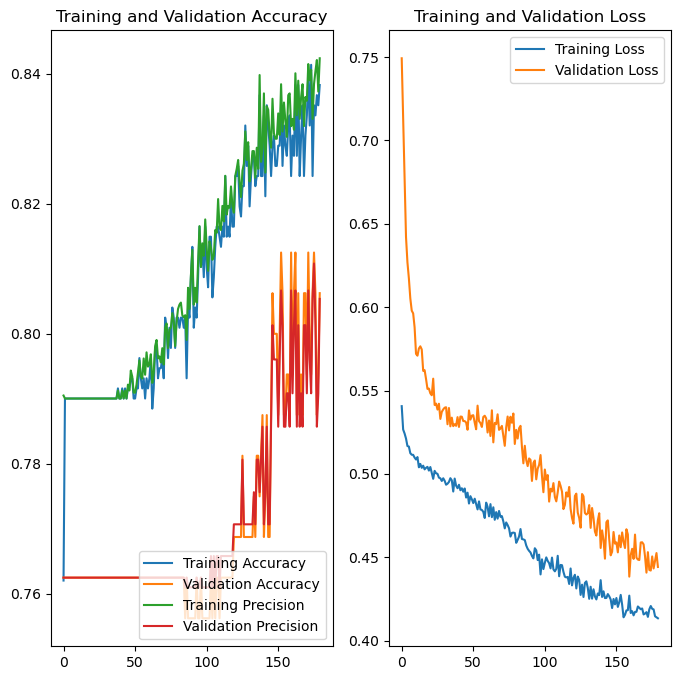

5/5 [==============================] - 0s 17ms/step


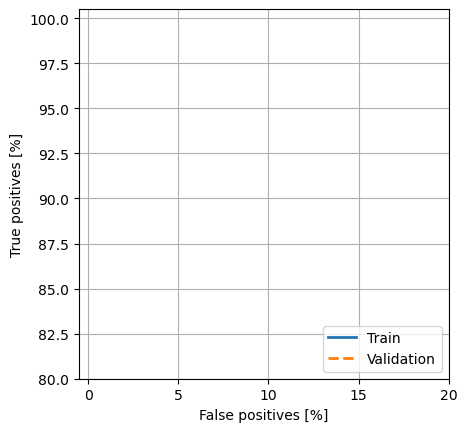

Found 201 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.7562189102172852
7/7 [==============================] - 0s 18ms/step - loss: 0.5100 - binary_accuracy: 0.7562 - precision: 0.7754 - auc: 0.7446 - recall: 0.9539 - true_negatives: 7.0000 - false_positives: 42.0000 - false_negatives: 7.0000 - true_positives: 145.0000           
{'loss': 0.5100099444389343, 'binary_accuracy': 0.7562189102172852, 'precision': 0.7754010558128357, 'auc': 0.7445623278617859, 'recall': 0.9539473652839661, 'true_negatives': 7.0, 'false_positives': 42.0, 'false_negatives': 7.0, 'true_positives': 145.0, 'f1': 0.8554572175362171}
Found 803 files belonging to 2 classes.
Using 643 files for training.
Using 160 files for validation.
The mean label value of samples in your train set is: 0.7900466322898865
The mean label value of samples in your validation set is: 0.762499988079071
Epoch 1/500
21/21 [==============================] - 3s 92ms/step - loss: 0.4543 - binary_accur

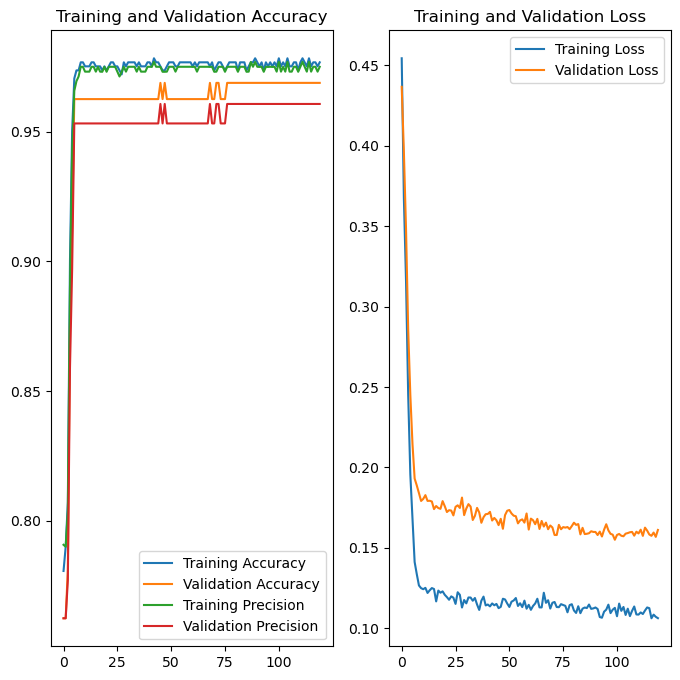

5/5 [==============================] - 0s 17ms/step


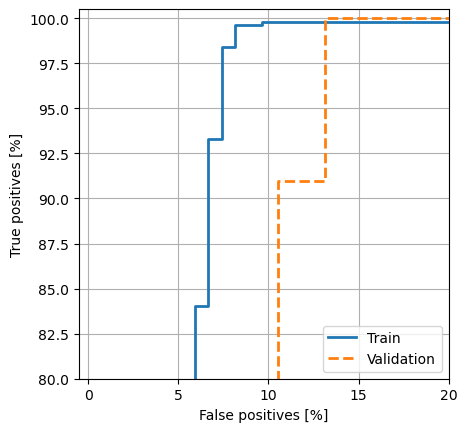

Found 201 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.7562189102172852
7/7 [==============================] - 0s 18ms/step - loss: 0.1109 - binary_accuracy: 0.9751 - precision: 0.9682 - auc: 0.9698 - recall: 1.0000 - true_negatives: 44.0000 - false_positives: 5.0000 - false_negatives: 0.0000e+00 - true_positives: 152.0000       
{'loss': 0.11094130575656891, 'binary_accuracy': 0.9751243591308594, 'precision': 0.9681528806686401, 'auc': 0.9697905778884888, 'recall': 1.0, 'true_negatives': 44.0, 'false_positives': 5.0, 'false_negatives': 0.0, 'true_positives': 152.0, 'f1': 0.983818777675167}
Found 811 files belonging to 2 classes.
Using 649 files for training.
Using 162 files for validation.
The mean label value of samples in your train set is: 0.6610169410705566
The mean label value of samples in your validation set is: 0.6481481194496155
Epoch 1/500
21/21 [==============================] - 3s 93ms/step - loss: 0.6776 - binary_accuracy: 0.6364 - 

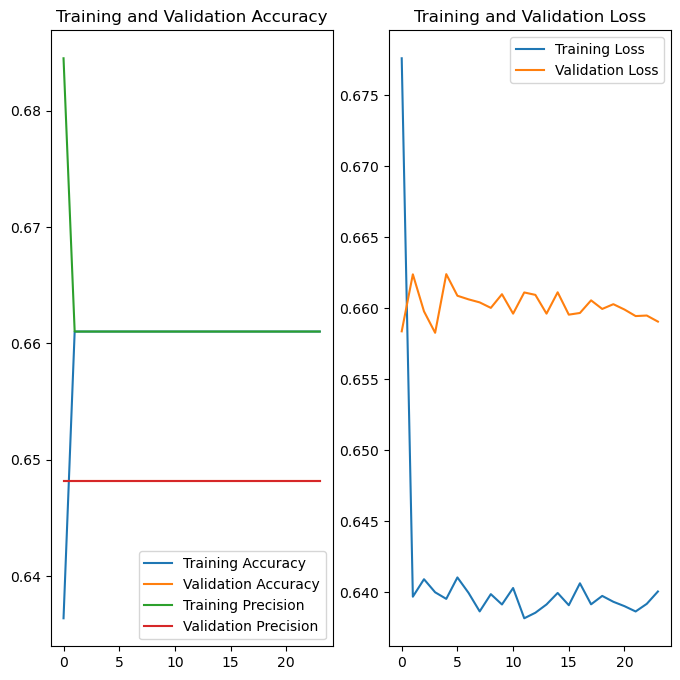

6/6 [==============================] - 0s 14ms/step


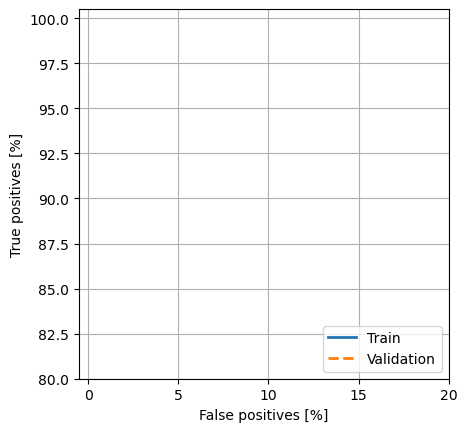

Found 205 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6341463327407837
7/7 [==============================] - 0s 18ms/step - loss: 0.6710 - binary_accuracy: 0.6341 - precision: 0.6341 - auc: 0.5470 - recall: 1.0000 - true_negatives: 0.0000e+00 - false_positives: 75.0000 - false_negatives: 0.0000e+00 - true_positives: 130.0000           
{'loss': 0.671043872833252, 'binary_accuracy': 0.6341463327407837, 'precision': 0.6341463327407837, 'auc': 0.5469743609428406, 'recall': 1.0, 'true_negatives': 0.0, 'false_positives': 75.0, 'false_negatives': 0.0, 'true_positives': 130.0, 'f1': 0.7761193964523312}
Found 811 files belonging to 2 classes.
Using 649 files for training.
Using 162 files for validation.
The mean label value of samples in your train set is: 0.6610169410705566
The mean label value of samples in your validation set is: 0.6481481194496155
Epoch 1/500
21/21 [==============================] - 3s 93ms/step - loss: 0.6197 - binary_accuracy: 0.

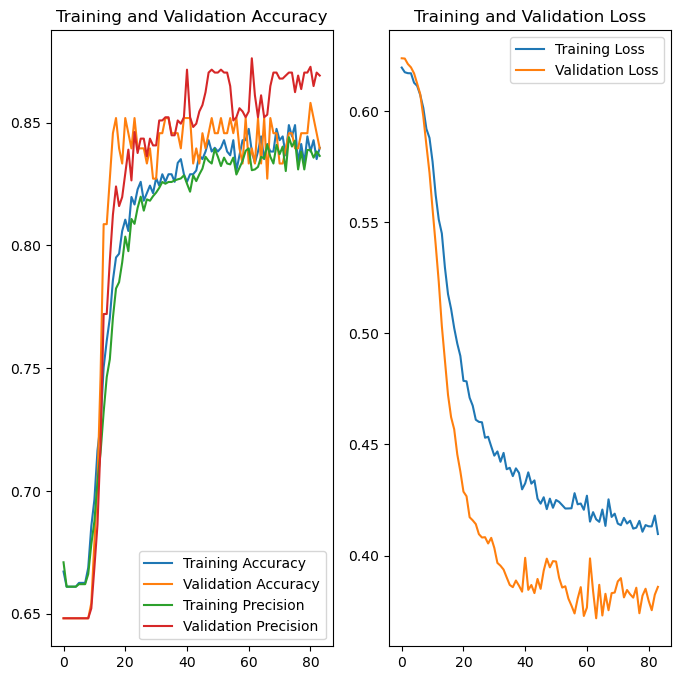

6/6 [==============================] - 0s 15ms/step


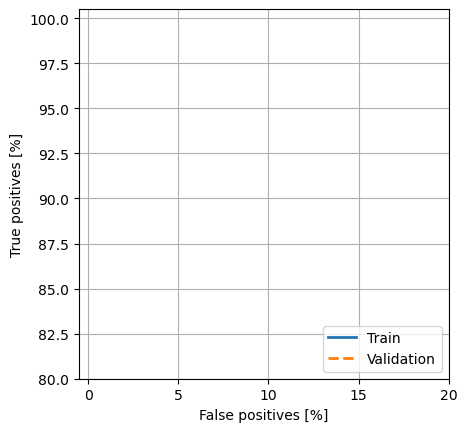

Found 205 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6341463327407837
7/7 [==============================] - 0s 20ms/step - loss: 0.4329 - binary_accuracy: 0.8195 - precision: 0.8298 - auc: 0.8521 - recall: 0.9000 - true_negatives: 51.0000 - false_positives: 24.0000 - false_negatives: 13.0000 - true_positives: 117.0000           
{'loss': 0.4329254627227783, 'binary_accuracy': 0.8195121884346008, 'precision': 0.8297872543334961, 'auc': 0.852102518081665, 'recall': 0.8999999761581421, 'true_negatives': 51.0, 'false_positives': 24.0, 'false_negatives': 13.0, 'true_positives': 117.0, 'f1': 0.8634686346993319}
Found 792 files belonging to 2 classes.
Using 634 files for training.
Using 158 files for validation.
The mean label value of samples in your train set is: 0.6198738217353821
The mean label value of samples in your validation set is: 0.6265822649002075
Epoch 1/500
20/20 [==============================] - 3s 95ms/step - loss: 0.7443 - binary_a

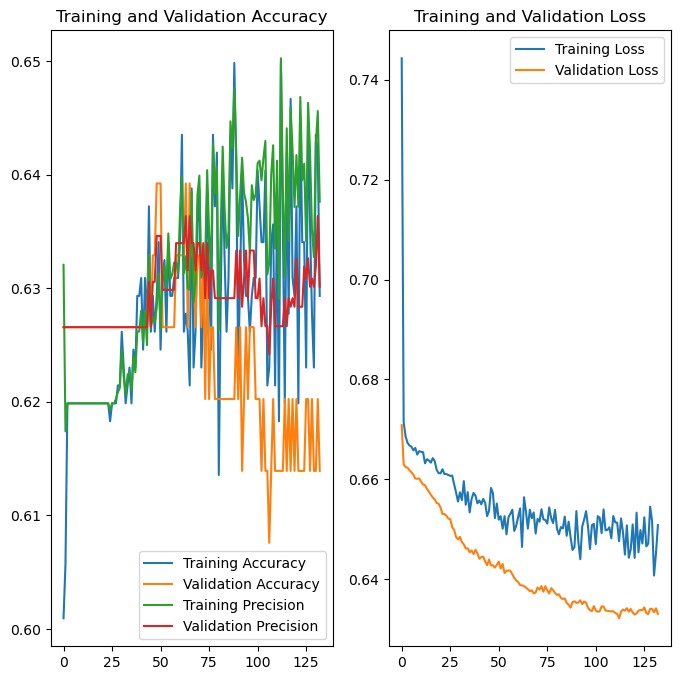

5/5 [==============================] - 0s 15ms/step


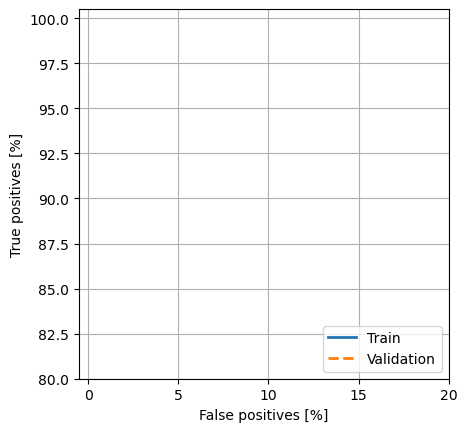

Found 199 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6180904507637024
7/7 [==============================] - 0s 36ms/step - loss: 0.6625 - binary_accuracy: 0.6281 - precision: 0.6269 - auc: 0.5558 - recall: 0.9837 - true_negatives: 4.0000 - false_positives: 72.0000 - false_negatives: 2.0000 - true_positives: 121.0000        
{'loss': 0.6625370979309082, 'binary_accuracy': 0.6281406879425049, 'precision': 0.6269429922103882, 'auc': 0.5558408498764038, 'recall': 0.9837398529052734, 'true_negatives': 4.0, 'false_positives': 72.0, 'false_negatives': 2.0, 'true_positives': 121.0, 'f1': 0.7658227798319304}
Found 792 files belonging to 2 classes.
Using 634 files for training.
Using 158 files for validation.
The mean label value of samples in your train set is: 0.6198738217353821
The mean label value of samples in your validation set is: 0.6265822649002075
Epoch 1/500
20/20 [==============================] - 3s 104ms/step - loss: 0.6454 - binary_accura

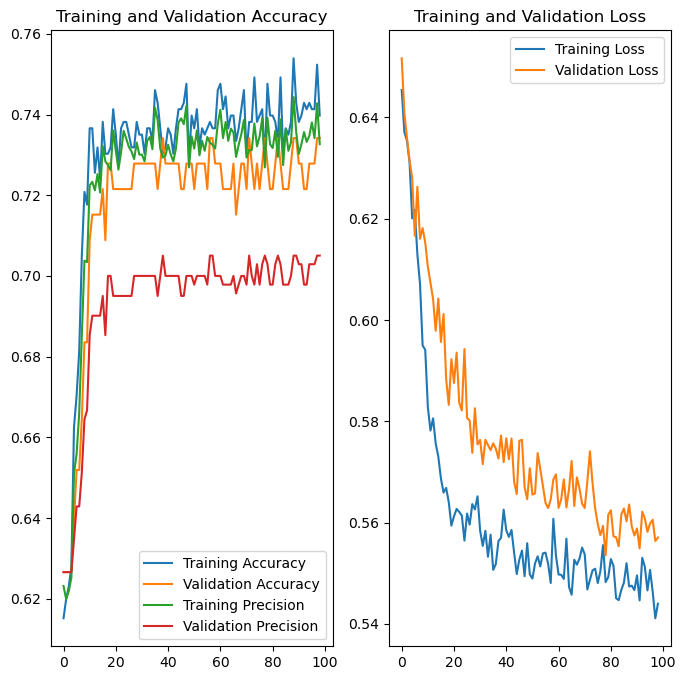

5/5 [==============================] - 0s 16ms/step


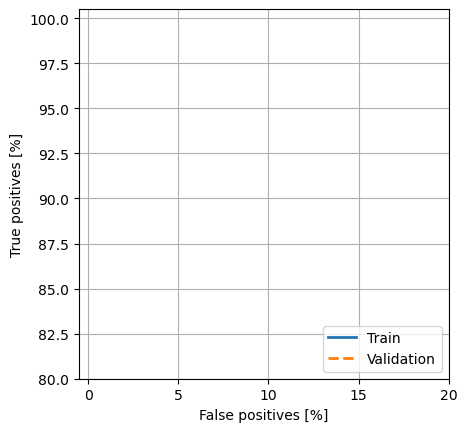

Found 199 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6180904507637024
7/7 [==============================] - 0s 17ms/step - loss: 0.5821 - binary_accuracy: 0.7387 - precision: 0.7178 - auc: 0.6999 - recall: 0.9512 - true_negatives: 30.0000 - false_positives: 46.0000 - false_negatives: 6.0000 - true_positives: 117.0000            
{'loss': 0.5821226239204407, 'binary_accuracy': 0.7386934757232666, 'precision': 0.7177914381027222, 'auc': 0.6998823285102844, 'recall': 0.9512194991111755, 'true_negatives': 30.0, 'false_positives': 46.0, 'false_negatives': 6.0, 'true_positives': 117.0, 'f1': 0.8181818309209296}
Found 795 files belonging to 2 classes.
Using 636 files for training.
Using 159 files for validation.
The mean label value of samples in your train set is: 0.650943398475647
The mean label value of samples in your validation set is: 0.6415094137191772
Epoch 1/500
20/20 [==============================] - 3s 98ms/step - loss: 0.6654 - binary_ac

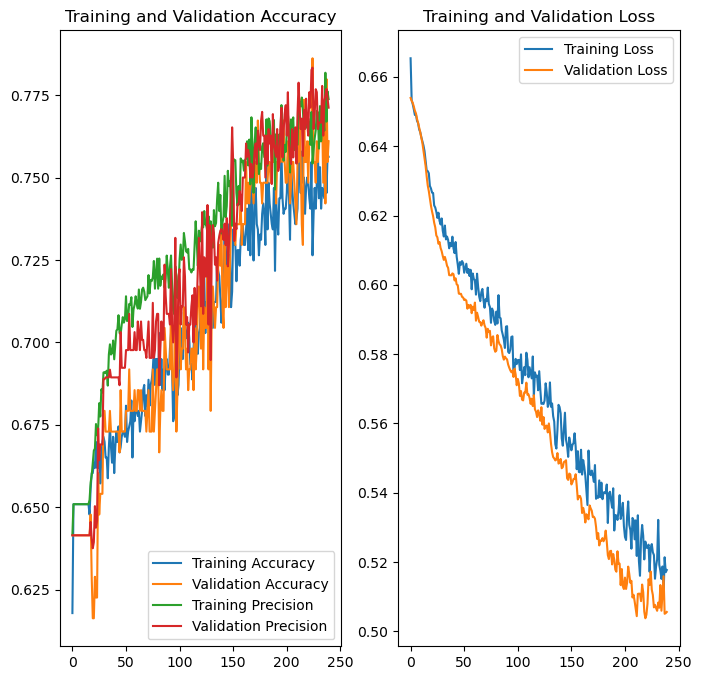

5/5 [==============================] - 0s 17ms/step


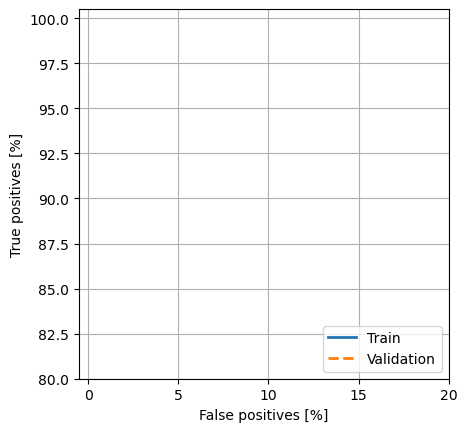

Found 198 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6868686676025391
7/7 [==============================] - 0s 17ms/step - loss: 0.5116 - binary_accuracy: 0.7475 - precision: 0.7688 - auc: 0.7878 - recall: 0.9044 - true_negatives: 25.0000 - false_positives: 37.0000 - false_negatives: 13.0000 - true_positives: 123.0000          
{'loss': 0.5115624070167542, 'binary_accuracy': 0.747474730014801, 'precision': 0.768750011920929, 'auc': 0.7877727746963501, 'recall': 0.904411792755127, 'true_negatives': 25.0, 'false_positives': 37.0, 'false_negatives': 13.0, 'true_positives': 123.0, 'f1': 0.8310810998898513}
Found 795 files belonging to 2 classes.
Using 636 files for training.
Using 159 files for validation.
The mean label value of samples in your train set is: 0.650943398475647
The mean label value of samples in your validation set is: 0.6415094137191772
Epoch 1/500
20/20 [==============================] - 3s 97ms/step - loss: 0.6041 - binary_accur

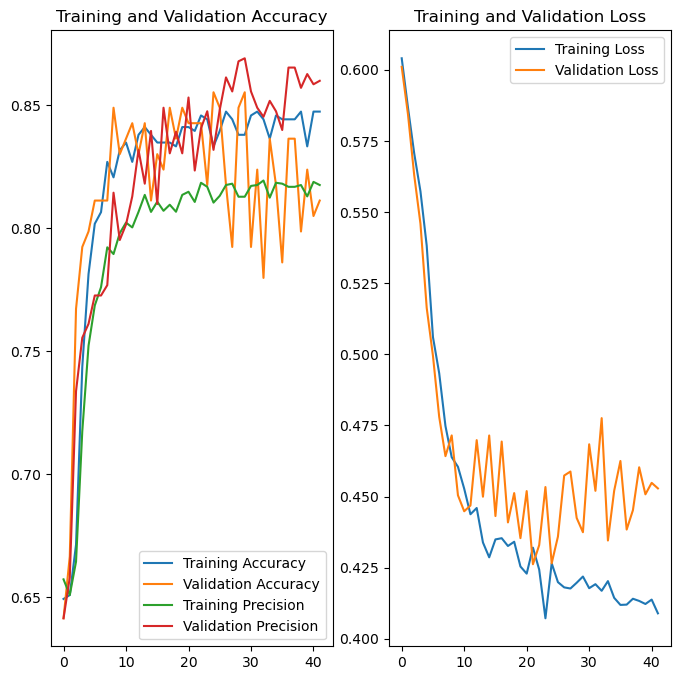

5/5 [==============================] - 0s 17ms/step


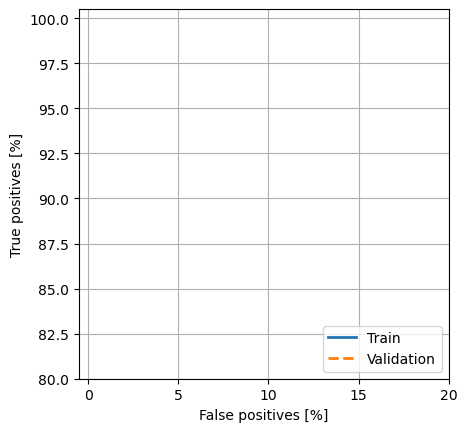

Found 198 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.6868686676025391
7/7 [==============================] - 0s 18ms/step - loss: 0.4898 - binary_accuracy: 0.7980 - precision: 0.8117 - auc: 0.7757 - recall: 0.9191 - true_negatives: 33.0000 - false_positives: 29.0000 - false_negatives: 11.0000 - true_positives: 125.0000          
{'loss': 0.48984241485595703, 'binary_accuracy': 0.7979797720909119, 'precision': 0.8116883039474487, 'auc': 0.7757352590560913, 'recall': 0.9191176295280457, 'true_negatives': 33.0, 'false_positives': 29.0, 'false_negatives': 11.0, 'true_positives': 125.0, 'f1': 0.8620689534403906}
Found 801 files belonging to 2 classes.
Using 641 files for training.
Using 160 files for validation.
The mean label value of samples in your train set is: 0.9266770482063293
The mean label value of samples in your validation set is: 0.9312499761581421
Epoch 1/500
21/21 [==============================] - 3s 92ms/step - loss: 0.2891 - binary_

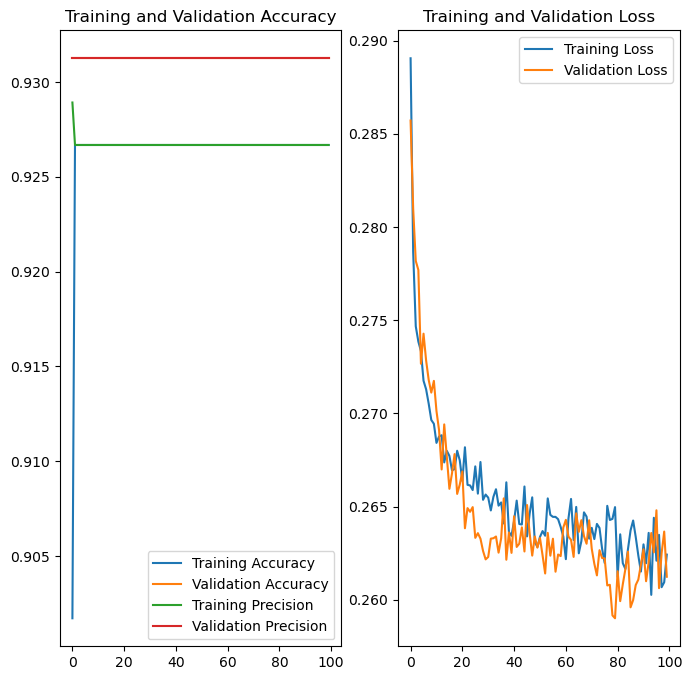

5/5 [==============================] - 0s 17ms/step


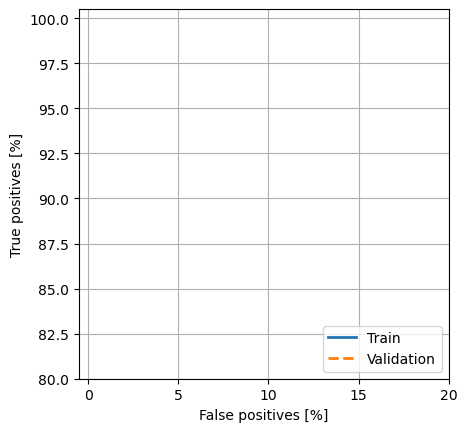

Found 201 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.93034827709198
7/7 [==============================] - 0s 21ms/step - loss: 0.2634 - binary_accuracy: 0.9303 - precision: 0.9303 - auc: 0.6245 - recall: 1.0000 - true_negatives: 0.0000e+00 - false_positives: 14.0000 - false_negatives: 0.0000e+00 - true_positives: 187.0000
{'loss': 0.2633771002292633, 'binary_accuracy': 0.93034827709198, 'precision': 0.93034827709198, 'auc': 0.6245225667953491, 'recall': 1.0, 'true_negatives': 0.0, 'false_positives': 14.0, 'false_negatives': 0.0, 'true_positives': 187.0, 'f1': 0.9639175356413152}
Found 801 files belonging to 2 classes.
Using 641 files for training.
Using 160 files for validation.
The mean label value of samples in your train set is: 0.9266770482063293
The mean label value of samples in your validation set is: 0.9312499761581421
Epoch 1/500
21/21 [==============================] - 3s 92ms/step - loss: 0.3144 - binary_accuracy: 0.9251 - precision

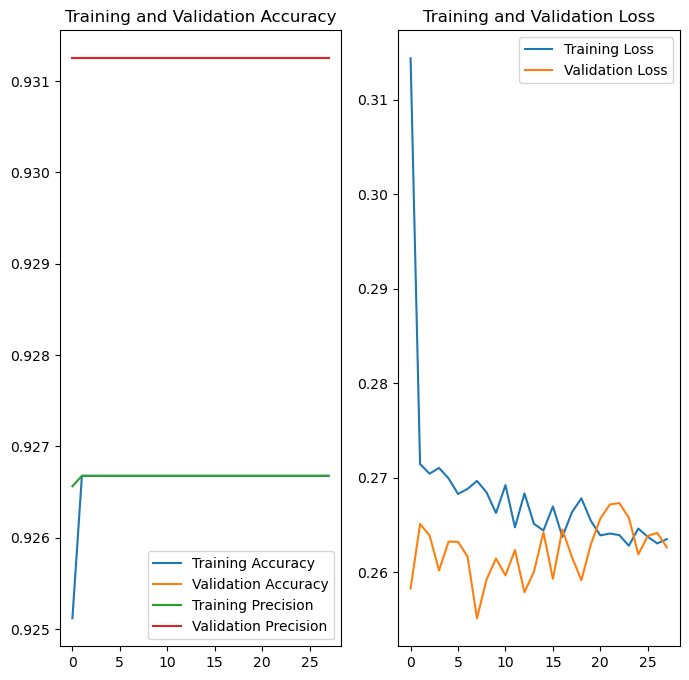

5/5 [==============================] - 0s 16ms/step


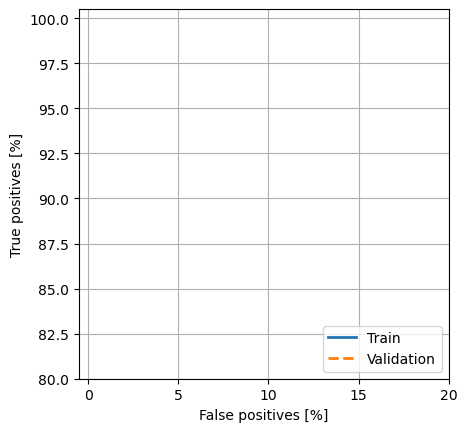

Found 201 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.93034827709198
7/7 [==============================] - 0s 18ms/step - loss: 0.2666 - binary_accuracy: 0.9303 - precision: 0.9303 - auc: 0.5430 - recall: 1.0000 - true_negatives: 0.0000e+00 - false_positives: 14.0000 - false_negatives: 0.0000e+00 - true_positives: 187.0000
{'loss': 0.26661375164985657, 'binary_accuracy': 0.93034827709198, 'precision': 0.93034827709198, 'auc': 0.5429717302322388, 'recall': 1.0, 'true_negatives': 0.0, 'false_positives': 14.0, 'false_negatives': 0.0, 'true_positives': 187.0, 'f1': 0.9639175356413152}
Found 4002 files belonging to 2 classes.
Using 3202 files for training.
Using 800 files for validation.
The mean label value of samples in your train set is: 0.7251717448234558
The mean label value of samples in your validation set is: 0.7412499785423279
Epoch 1/500
101/101 [==============================] - 10s 89ms/step - loss: 0.6159 - binary_accuracy: 0.7236 - pre

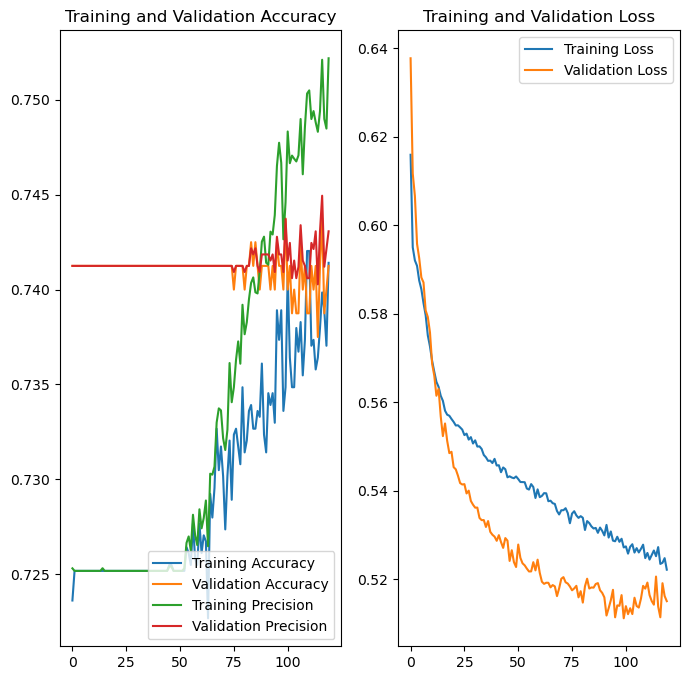

25/25 [==============================] - 0s 17ms/step


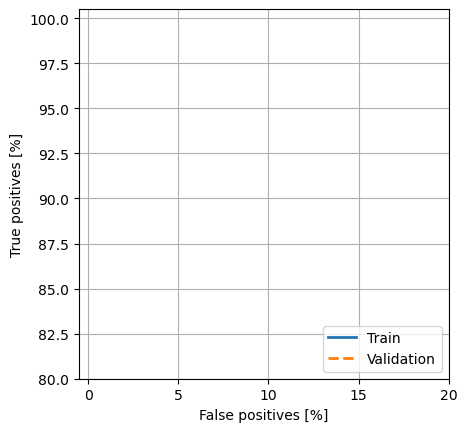

Found 1004 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.7250996232032776
32/32 [==============================] - 1s 21ms/step - loss: 0.5429 - binary_accuracy: 0.7241 - precision: 0.7262 - auc: 0.7009 - recall: 0.9945 - true_negatives: 3.0000 - false_positives: 273.0000 - false_negatives: 4.0000 - true_positives: 724.0000    
{'loss': 0.5428764224052429, 'binary_accuracy': 0.724103569984436, 'precision': 0.7261785268783569, 'auc': 0.7008704543113708, 'recall': 0.9945054650306702, 'true_negatives': 3.0, 'false_positives': 273.0, 'false_negatives': 4.0, 'true_positives': 724.0, 'f1': 0.8394202735241458}
Found 4002 files belonging to 2 classes.
Using 3202 files for training.
Using 800 files for validation.
The mean label value of samples in your train set is: 0.7251717448234558
The mean label value of samples in your validation set is: 0.7412499785423279
Epoch 1/500
101/101 [==============================] - 10s 89ms/step - loss: 0.5278 - binary_ac

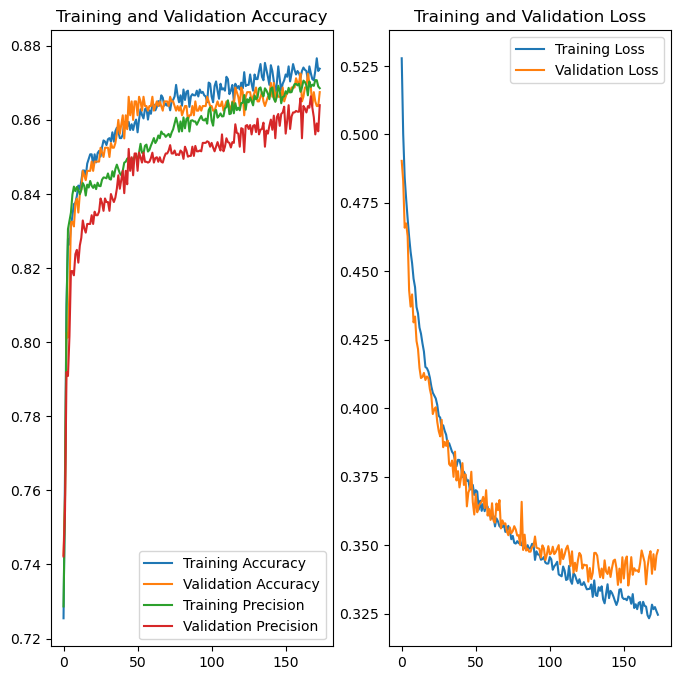

25/25 [==============================] - 0s 17ms/step


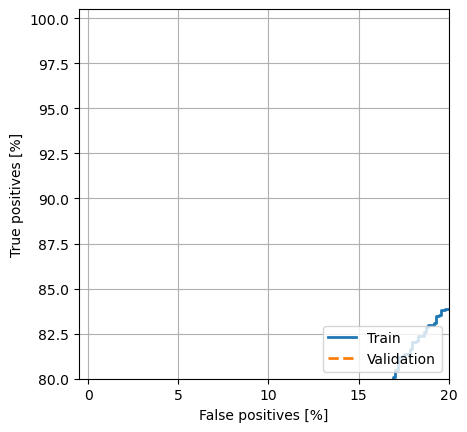

Found 1004 files belonging to 2 classes.
The mean label value of samples in your test set is: 0.7250996232032776
32/32 [==============================] - 1s 20ms/step - loss: 0.3698 - binary_accuracy: 0.8586 - precision: 0.8522 - auc: 0.8662 - recall: 0.9739 - true_negatives: 153.0000 - false_positives: 123.0000 - false_negatives: 19.0000 - true_positives: 709.0000
{'loss': 0.36981508135795593, 'binary_accuracy': 0.8585657477378845, 'precision': 0.8521634340286255, 'auc': 0.8662083148956299, 'recall': 0.973901093006134, 'true_negatives': 153.0, 'false_positives': 123.0, 'false_negatives': 19.0, 'true_positives': 709.0, 'f1': 0.9089743407567341}


In [10]:
tf.keras.utils.set_random_seed(235)

species = ["Alnus_glutinosa","Betula_pendula","Betula_pubescens","Pinus_sylvestris","Sorbus_aucuparia","all_species"]
types = ["colour","xray"]

for i in species:
    for j in types:

        training_folder=os.path.join("data/individual_seed_images/",i,j,"training")
        testing_folder=os.path.join("data/individual_seed_images/",i,j,"testing")
        new_folder=os.path.join("data/individual_seed_images/",i,j,"training")
        log_file_name = f'{i}_{j}_log.csv'
        csv_log_path=os.path.join("outputs/CNNs",log_file_name)
        

        trained_model = set_up_and_fit_model(training_folder, csv_log_path=csv_log_path)

        test_ds=load_test_data(testing_folder, img_size=(IMG_HEIGHT, IMG_WIDTH))

        predictions = trained_model.predict(test_ds)
        binary_predictions = tf.where(predictions < 0.5,0, 1).numpy().flatten()
        # Combine file paths and predictions
        results = pd.DataFrame({'file_path': test_ds.file_paths, 'prediction': binary_predictions})
        
        def get_class_from_filepath(file_path:str):
            return int(os.path.basename(os.path.dirname(file_path)))
        
        results['real_class'] = results['file_path'].apply(get_class_from_filepath)

        file_name = f'bin_pred_{i}_{j}.csv'
        file_path = os.path.join("outputs/CNNs", file_name)
        results.to_csv(file_path, index=False)

        evaluation = trained_model.evaluate(test_ds, return_dict=True)
        if (evaluation['precision'] + evaluation['recall']) >0:
            f1 = 2 * evaluation['precision'] * evaluation['recall'] / (evaluation['precision'] + evaluation['recall'])
        else:
            f1 = np.nan
        evaluation['f1'] = f1

        print(evaluation)
        
        df = pd.DataFrame([evaluation])
        file_name = f'evaluation_{i}_{j}.csv'
        file_path = os.path.join("outputs/CNNs", file_name)
        df.to_csv(file_path, index=False)
        
        